In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from scipy import stats

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [17]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = [
    "naive",
    "mvo",
    "bl",
    "linear-ridge",
]

In [18]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] #+ pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [19]:
import numpy as np
import pandas as pd

data_factors = pd.read_csv('data/inputs/fredmd_factors_raw.csv')
transformation_codes = data_factors.iloc[0]
data_factors = data_factors.drop(0)
transformation_codes = transformation_codes.to_dict()
del transformation_codes['sasdate']

small = 1e-6
for column in data_factors.columns:
    if column in transformation_codes:
        match int(transformation_codes[column]):
            case 1:
                data_factors[column] = data_factors[column]

            case 2: # First difference: x(t)-x(t-1)
                data_factors[column] = data_factors[column].diff()

            case 3: # Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
                data_factors[column] = data_factors[column].diff().diff()

            case 4: # Natural log: ln(x)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)

            case 5: # First difference of natural log: ln(x)-ln(x-1)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff()

            case 6: # Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff().diff()

            case 7: # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
                data_factors[column] = data_factors[column].pct_change()
                data_factors[column] = data_factors[column].diff()

data_factors = data_factors.drop([1, 2]).reset_index(drop=True)

data_factors = data_factors.ffill()
data_factors = data_factors.fillna(0.0)

data_factors['sasdate'] = pd.to_datetime(data_factors['sasdate'], format='%m/%d/%Y')
data_factors = data_factors.rename(columns={'sasdate': 'date'})
data_factors = data_factors.set_index('date')


from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

df_normalized = data_factors

# You must normalize the data before applying the fit method
df_normalized=(df_normalized - df_normalized.mean()) / df_normalized.std()
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_normalized.columns)
print(loadings)

DESIRE_EXPLAINED_VARIANCE = 0.95
total_explained_variance = 0.0
for i, x in enumerate(pca.explained_variance_ratio_):
    total_explained_variance += x
    if total_explained_variance >= DESIRE_EXPLAINED_VARIANCE:
        print(f"Number of components to explain {DESIRE_EXPLAINED_VARIANCE * 100}% variance: {i+1}")
        break
n_components = i+1

# Use the top n components to transform the data
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)
df_transformed = pd.DataFrame(pca.transform(df_normalized),
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=df_normalized.index)
df_transformed = df_transformed[['PC%s' % _ for _ in range(n_components)]]

print(df_transformed)

memory_data = df_transformed

                      PC0       PC1       PC2       PC3       PC4       PC5  \
RPI             -0.032678 -0.047984 -0.000752  0.025343  0.063781  0.045892   
W875RX1          0.112550 -0.068211  0.038119 -0.032999  0.006149 -0.006541   
DPCERA3M086SBEA  0.146550  0.027131  0.060616 -0.042417 -0.018647  0.143320   
CMRMTSPLx        0.135673 -0.008126  0.053135 -0.014012  0.024570  0.093309   
RETAILx          0.127633  0.065554  0.019088 -0.035344  0.000766  0.146614   
...                   ...       ...       ...       ...       ...       ...   
UMCSENTx         0.037855  0.012142  0.030014  0.014400 -0.012411  0.098975   
DTCOLNVHFNM      0.002451  0.009939 -0.011267  0.016205 -0.015283  0.058104   
DTCTHFNM         0.006255  0.013653 -0.012419  0.018355 -0.013001  0.032122   
INVEST           0.015517  0.016652  0.007961 -0.011221 -0.015233 -0.019285   
VIXCLSx         -0.052323  0.001555 -0.009238 -0.039914 -0.001340  0.121704   

                      PC6       PC7       PC8      

In [20]:
# get regimes
#memory_dir_name = "kmeans_elbow"
memory_dir_name = 'kmeans'
memory_results_path = os.path.join("data", "inputs", "memory", memory_dir_name, "results.pkl")
memory_results = pd.read_pickle(memory_results_path)
regimes = memory_results["regimes"]
centroids = memory_results["centroids"]
regimes_probs = memory_results["regimes_probs"]

In [21]:
pd.DataFrame(memory_data.columns)

0
0    PC0
1    PC1
2    PC2
3    PC3
4    PC4
..   ...
56  PC56
57  PC57
58  PC58
59  PC59
60  PC60

[61 rows x 1 columns]

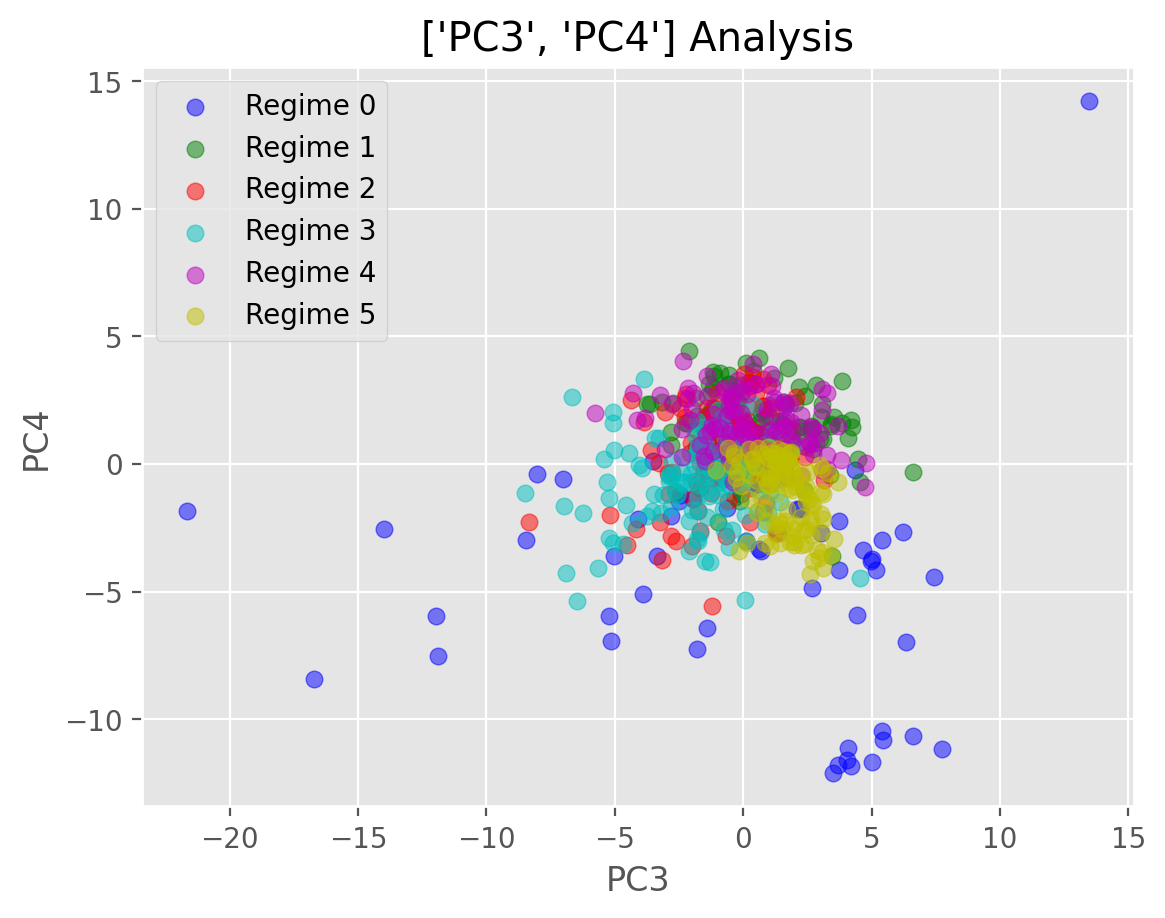

In [22]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_vars = ['PC3', 'PC4']

plt.clf()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(6):
    plt.scatter(memory_data[macro_vars[0]][:-1][regimes['cluster_step697'] == i], memory_data[macro_vars[1]][:-1][regimes['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
plt.title(f"{macro_vars} Analysis")
plt.xlabel(macro_vars[0])
plt.ylabel(macro_vars[1])
plt.legend()
plt.show()

In [23]:
# etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
# macro_var = 'PC0'

# for etf in etfs:
#     plt.clf()
#     colors = ['b', 'g', 'r', 'c', 'm', 'y']
#     for i in range(6):
#         plt.scatter(memory_data[-275:][macro_var][regimes[-275:]['cluster_step697'] == i],
#                     returns[etf][regimes[-275:]['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
#     plt.title(f"{etf} / {macro_var} Analysis")
#     plt.xlabel(macro_var)
#     plt.ylabel(etf + " Returns")
#     plt.legend()
#     plt.show()

In [24]:
all_portfolio_returns = []
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
line_types = ['-', '--', '-.', ':']
styles = ['m', 'c']
style_map = {}
for method in portfolio_methods:
    print(method)
    cur_color = colors.pop(0)
    dirs = os.listdir(os.path.join(outputs_path, method))

    for i, dir in enumerate(dirs):
        cur_line_type = line_types[i % len(line_types)]
        styles.append(f"{cur_color}{cur_line_type}")
        style_map[method + dir.split('/')[-1][7:-4]] = f"{cur_color}{cur_line_type}"
        print(method, dir)

        try:
            results = load_pickle(os.path.join(outputs_path, method, dir))
        except:
            print(method, dir)
            continue

        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # match columns
        forecasts = forecasts[returns.columns]

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

naive
naive results_mx_4_rand.pkl
naive results_lns_3_rand.pkl
naive results_lns_2_rand.pkl
naive results_mx_4.pkl
naive results_lo_4_rand.pkl
naive results_mx_2.pkl
naive results_mx_3.pkl
naive results_lns_4.pkl
naive results_lo_2.pkl
naive results_lo_2_rand.pkl
naive results_lo_3_rand.pkl
naive results_lo_3.pkl
naive results_mx_2_rand.pkl
naive results_mx_3_rand.pkl
naive results_lns_3.pkl
naive results_lns_4_rand.pkl
naive results_lns_2.pkl
naive results_lo_4.pkl
naive results_los_2_rand.pkl
naive results_los_3_rand.pkl
naive results_los_4.pkl
naive results_los_4_rand.pkl
naive results_los_2.pkl
naive results_los_3.pkl
mvo
mvo results_lns_4.pkl
mvo results_lo_2.pkl
mvo results_lo_3.pkl
mvo results_lns_3.pkl
mvo results_lns_2.pkl
mvo results_lo_4.pkl
bl
bl results_lns_3_rand.pkl
bl results_lns_2_rand.pkl
bl results_lo_4_rand.pkl
bl results_lns_4.pkl
bl results_lo_2.pkl
bl results_lo_2_rand.pkl
bl results_lo_3_rand.pkl
bl results_lo_3.pkl
bl results_lns_3.pkl
bl results_lns_4_rand.pkl

In [25]:
%config InlineBackend.figure_format = 'retina'
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
concat_list = [equal_weight_cumm_returns, spy_cumm_returns]

model_list = all_portfolio_returns_df["models"].unique()
model_list = [
    'naive_lns_2',
    'naive_mx_2',
    'naive_los_2',
    'naive_lo_2',
    'naive_lns_3',
    'naive_mx_3',
    'naive_los_3',
    'naive_lo_3',
    'naive_mx_4',
    'naive_lns_4',
    'naive_los_4',
    'naive_lo_4',

    'naive_lns_2_rand',
    'naive_mx_2_rand',
    'naive_los_2_rand',
    'naive_lo_2_rand',
    'naive_lns_3_rand',
    'naive_mx_3_rand',
    'naive_los_3_rand',
    'naive_lo_3_rand',
    'naive_lns_4_rand',
    'naive_mx_4_rand',
    'naive_los_4_rand',
    'naive_lo_4_rand',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',

    'bl_lns_2',
    'bl_lo_2',
    'bl_lns_3',
    'bl_lo_3',
    'bl_lns_4',
    'bl_lo_4',

    'bl_lns_2_rand',
    'bl_lo_2_rand',
    'bl_lns_3_rand',
    'bl_lo_3_rand',
    'bl_lns_4_rand',
    'bl_lo_4_rand',

    'linear-ridge_lns_2',
    'linear-ridge_mx_2',
    'linear-ridge_los_2',
    'linear-ridge_lo_2',
    'linear-ridge_lns_3',
    'linear-ridge_mx_3',
    'linear-ridge_los_3',
    'linear-ridge_lo_3',
    'linear-ridge_lns_4',
    'linear-ridge_mx_4',
    'linear-ridge_los_4',
    'linear-ridge_lo_4',

    'linear-ridge_lns_2_rand',
    'linear-ridge_mx_2_rand',
    'linear-ridge_los_2_rand',
    'linear-ridge_lo_2_rand',
    'linear-ridge_lns_3_rand',
    'linear-ridge_mx_3_rand',
    'linear-ridge_los_3_rand',
    'linear-ridge_lo_3_rand',
    'linear-ridge_lns_4_rand',
    'linear-ridge_mx_4_rand',
    'linear-ridge_los_4_rand',
    'linear-ridge_lo_4_rand',
]
print(style_map)
styles = ['m', 'c'] + [style_map[model] for model in model_list]
for model in model_list:
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    # ax = tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cumulative Returns: Model = {model}")
    
    # # Place the legend outside the plot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))

{'naive_mx_4_rand': 'r-', 'naive_lns_3_rand': 'r--', 'naive_lns_2_rand': 'r-.', 'naive_mx_4': 'r:', 'naive_lo_4_rand': 'r-', 'naive_mx_2': 'r--', 'naive_mx_3': 'r-.', 'naive_lns_4': 'r:', 'naive_lo_2': 'r-', 'naive_lo_2_rand': 'r--', 'naive_lo_3_rand': 'r-.', 'naive_lo_3': 'r:', 'naive_mx_2_rand': 'r-', 'naive_mx_3_rand': 'r--', 'naive_lns_3': 'r-.', 'naive_lns_4_rand': 'r:', 'naive_lns_2': 'r-', 'naive_lo_4': 'r--', 'naive_los_2_rand': 'r-.', 'naive_los_3_rand': 'r:', 'naive_los_4': 'r-', 'naive_los_4_rand': 'r--', 'naive_los_2': 'r-.', 'naive_los_3': 'r:', 'mvo_lns_4': 'b-', 'mvo_lo_2': 'b--', 'mvo_lo_3': 'b-.', 'mvo_lns_3': 'b:', 'mvo_lns_2': 'b-', 'mvo_lo_4': 'b--', 'bl_lns_3_rand': 'g-', 'bl_lns_2_rand': 'g--', 'bl_lo_4_rand': 'g-.', 'bl_lns_4': 'g:', 'bl_lo_2': 'g-', 'bl_lo_2_rand': 'g--', 'bl_lo_3_rand': 'g-.', 'bl_lo_3': 'g:', 'bl_lns_3': 'g-', 'bl_lns_4_rand': 'g--', 'bl_lns_2': 'g-.', 'bl_lo_4': 'g:', 'linear-ridge_mx_4_rand': 'y-', 'linear-ridge_lns_3_rand': 'y--', 'linear-r

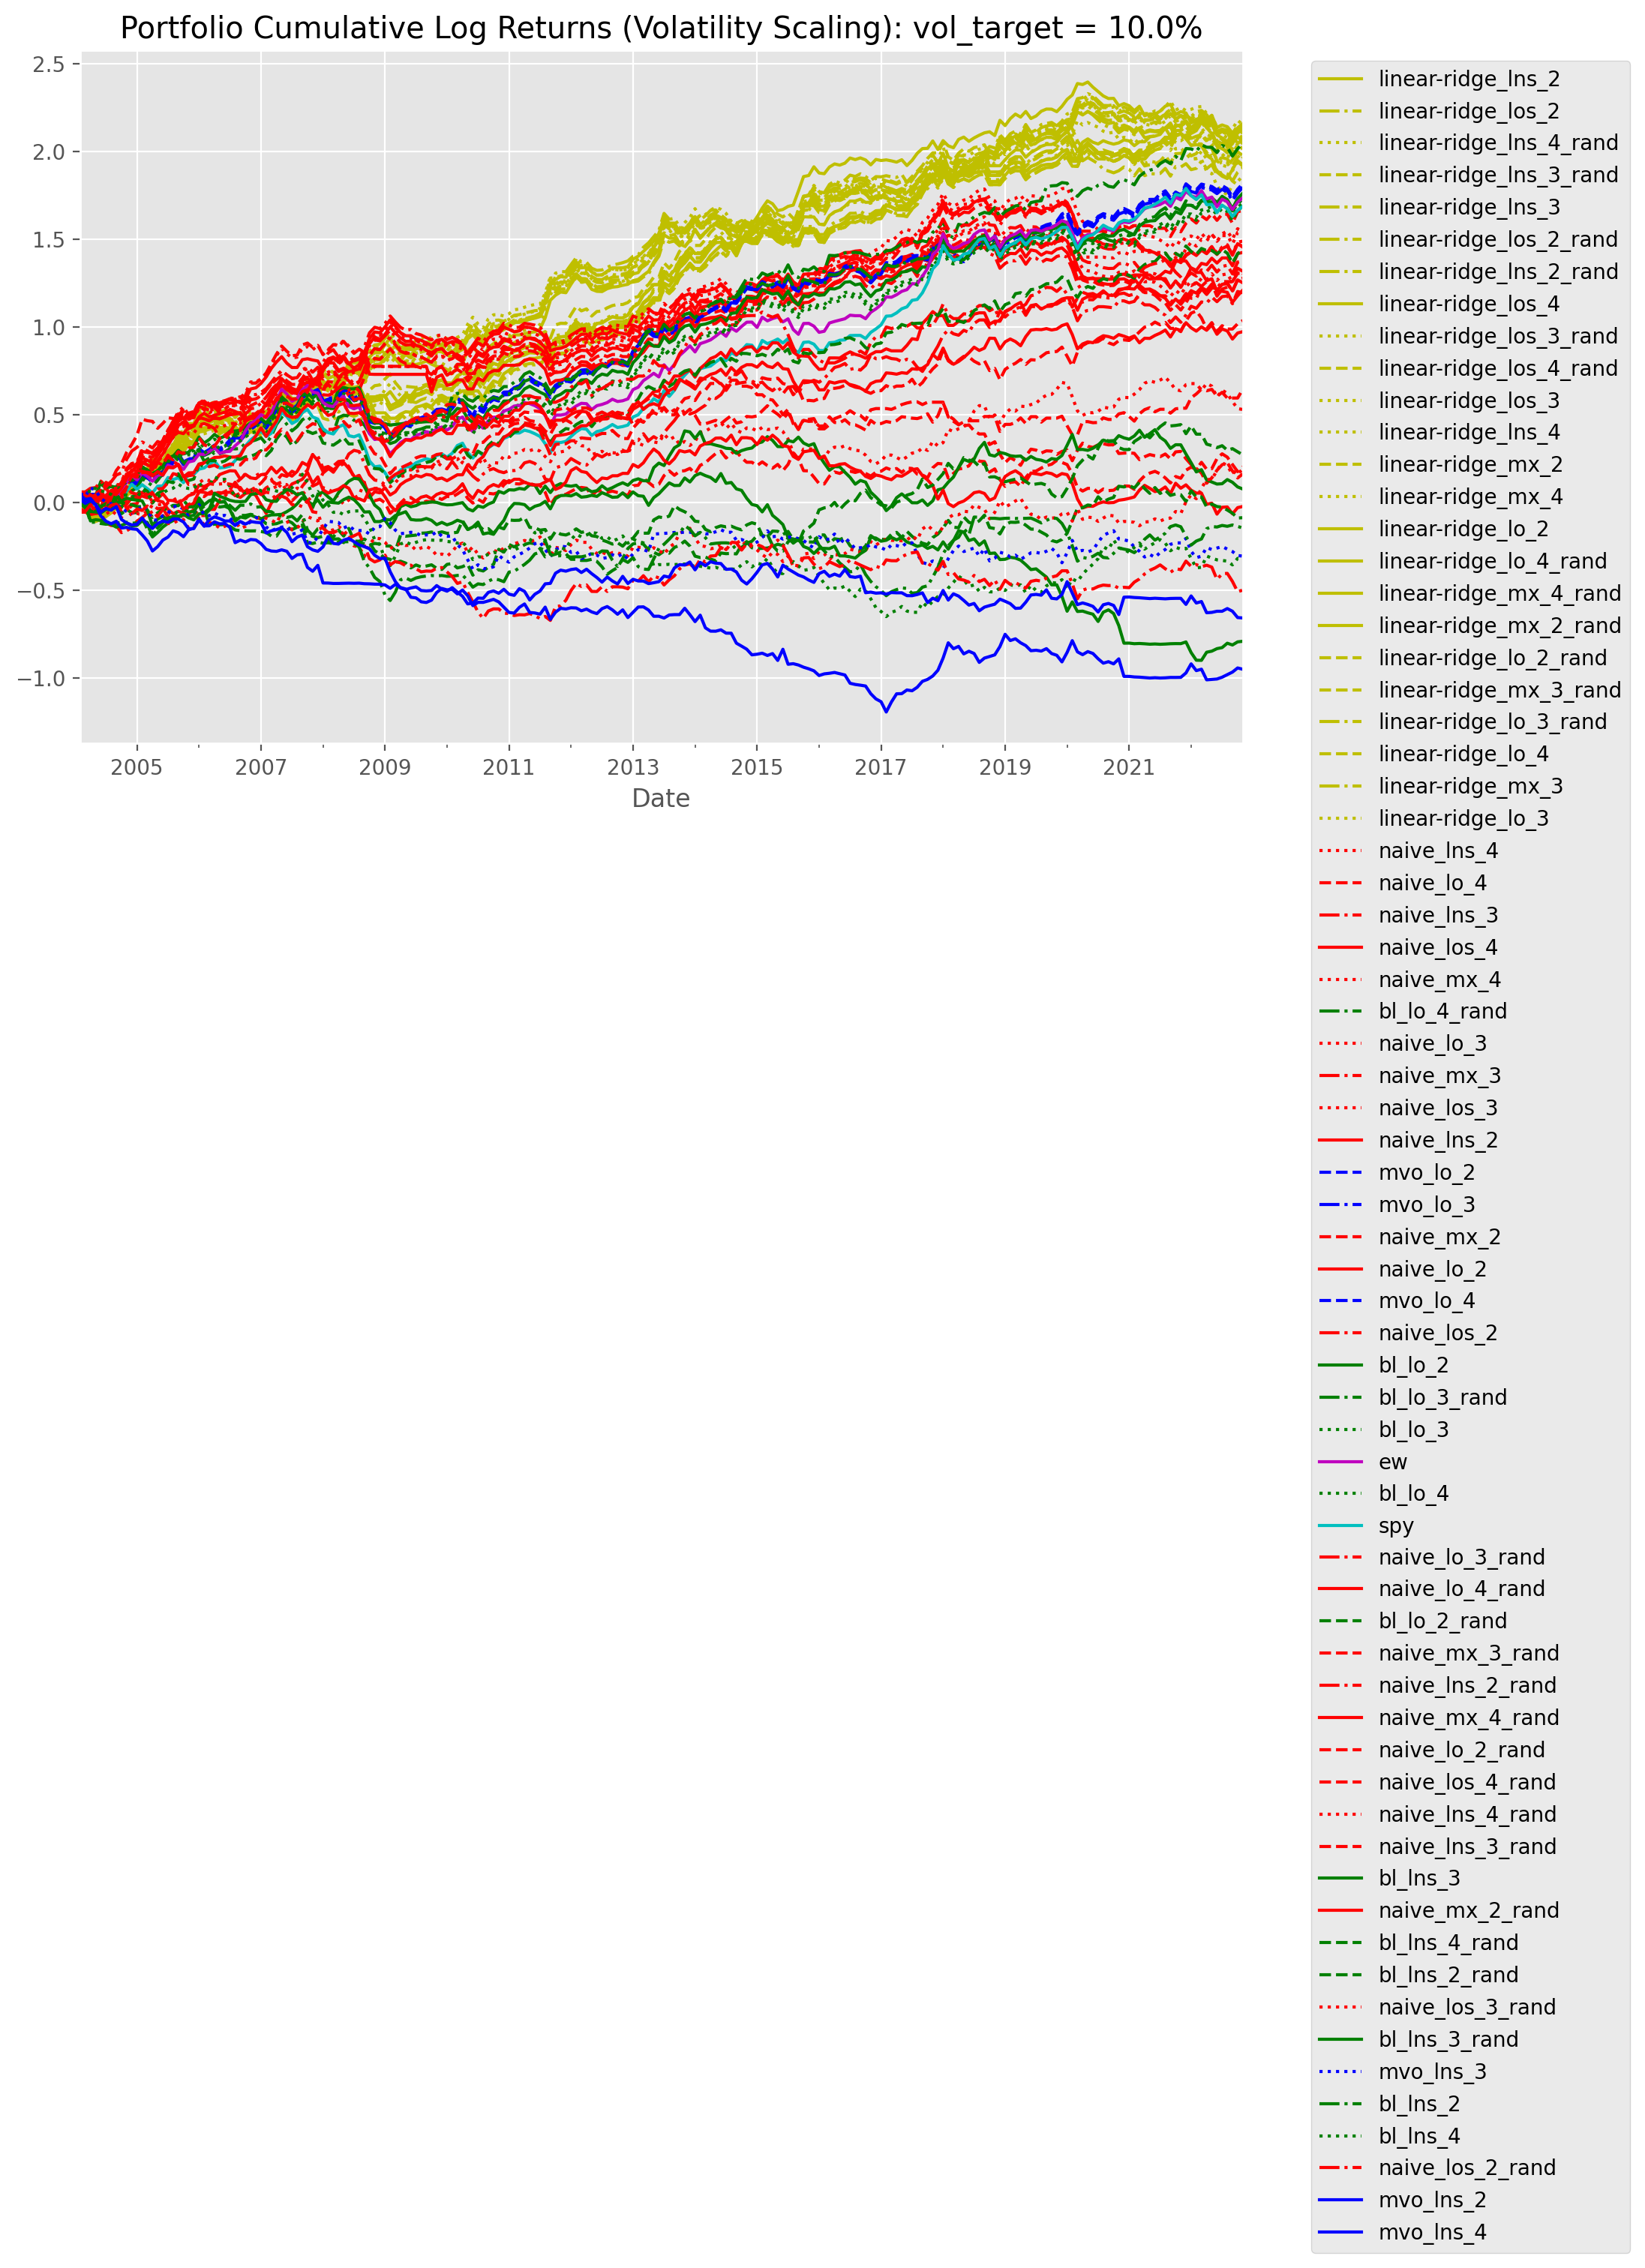

In [27]:
returns = pd.concat(concat_list, axis=1)
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index
order_style = list(cum_voladj_returns.mean(axis=0).argsort())
ax = cum_voladj_returns[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%", xlabel="Date")

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

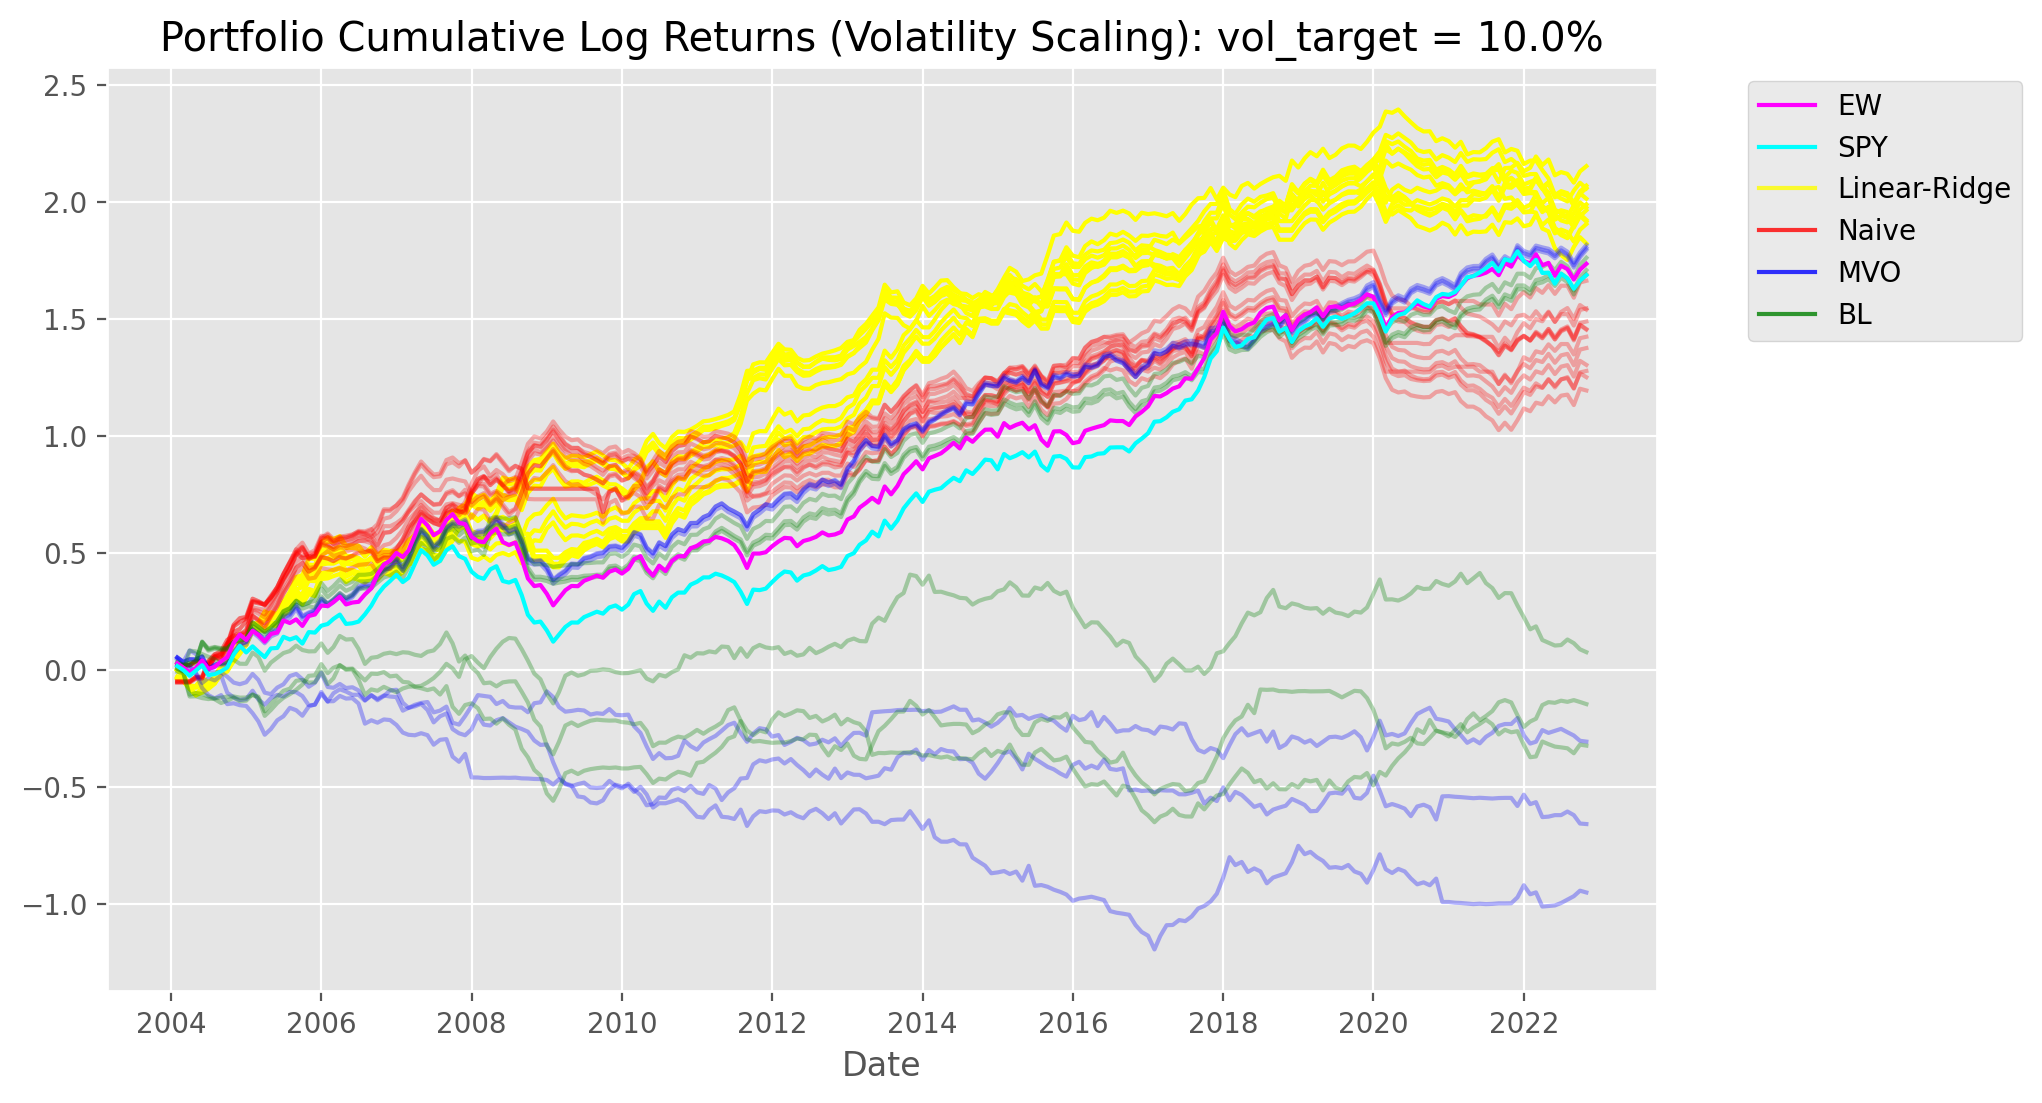

In [28]:
# Group models
linear_ridge_models = [m for m in returns.columns if (m.startswith('linear-ridge')) and (not m.endswith('rand'))]
naive_models = [m for m in returns.columns if (m.startswith('naive')) and (not m.endswith('rand'))]
mvo_models = [m for m in returns.columns if (m.startswith('mvo')) and (not m.endswith('rand'))]
bl_models = [m for m in returns.columns if (m.startswith('bl')) and (not m.endswith('rand'))]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group
for model in linear_ridge_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='yellow', alpha=1)
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='blue', alpha=0.3)
for model in bl_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='green', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='magenta', label='EW')
plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='cyan', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='yellow', label='Linear-Ridge', alpha=0.8)
plt.plot([], [], color='red', label='Naive', alpha=0.8)
plt.plot([], [], color='blue', label='MVO', alpha=0.8)
plt.plot([], [], color='green', label='BL', alpha=0.8)

plt.title(f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

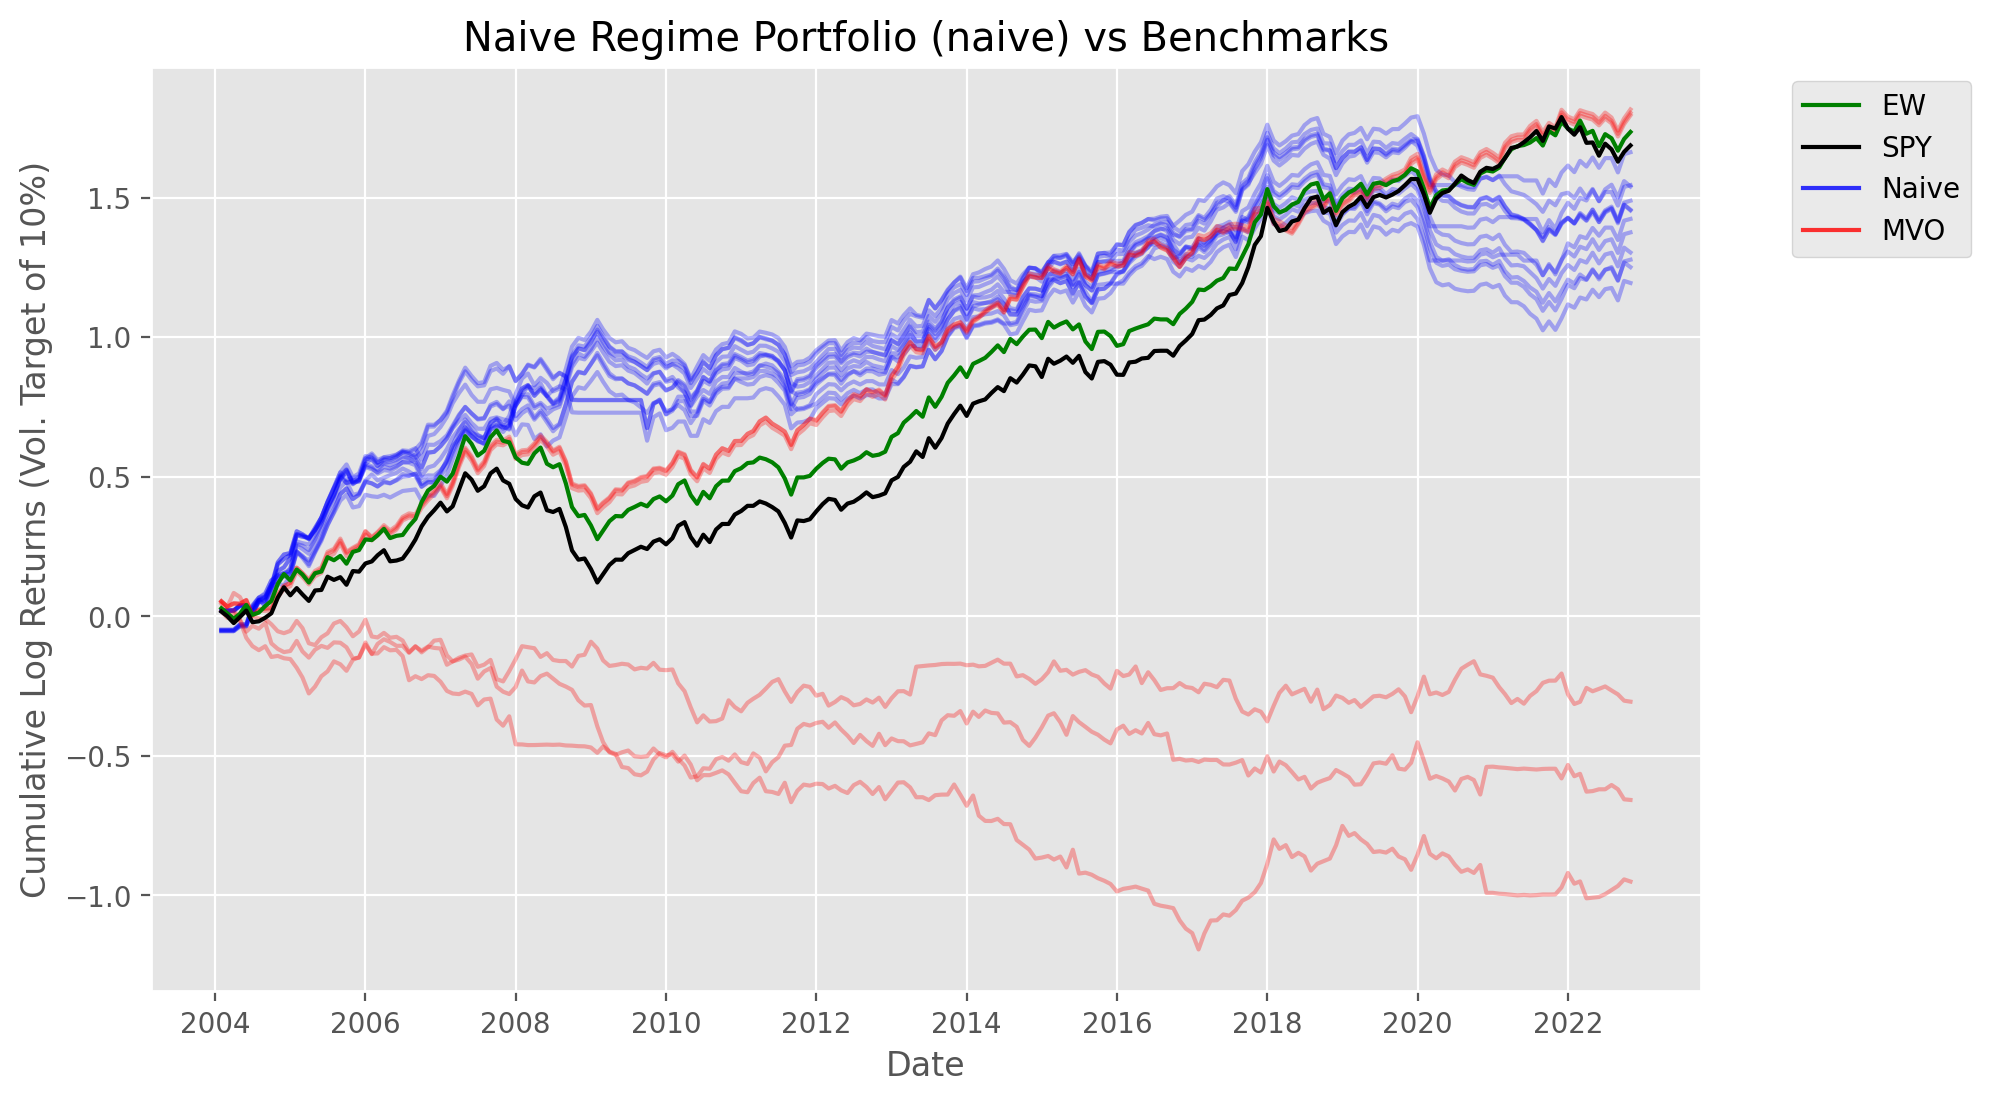

In [30]:
super_benchmarks = ['spy', 'ew']
selected_model_list = [
    'naive_lns_2',
    'naive_mx_2',
    'naive_los_2',
    'naive_lo_2',
    'naive_lns_3',
    'naive_mx_3',
    'naive_los_3',
    'naive_lo_3',
    'naive_mx_4',
    'naive_lns_4',
    'naive_los_4',
    'naive_lo_4',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if m.startswith('naive')]
mvo_models = [m for m in selected_model_list if m.startswith('mvo')]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='blue', alpha=0.3)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='blue', label='Naive', alpha=0.8)
plt.plot([], [], color='red', label='MVO', alpha=0.8)

plt.title(f"Naive Regime Portfolio (naive) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
cum_voladj_returns

In [36]:
all_summary_statistics = []
for model in cum_voladj_returns.columns:
    tmp_portfolio_returns = cum_voladj_returns[[model]].diff()

    tensor_tmp_portfolio_returns = torch.tensor(tmp_portfolio_returns.dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df.round(3)

E[R]  Std(R)  Sharpe  Sortino   AvgDD   MaxDD  % Positive Ret.
naive_lns_2  6.934  36.424   0.659    1.156  -7.469 -32.576            0.578
naive_mx_2   6.710  36.584   0.635    1.012  -7.098 -35.830            0.582
naive_los_2  6.652  36.475   0.632    1.033  -8.608 -35.792            0.578
naive_lo_2   7.489  37.296   0.696    0.910  -5.899 -23.968            0.538
naive_lns_3  8.020  36.775   0.755    1.334  -6.316 -29.142            0.556
naive_mx_3   7.225  36.650   0.683    1.123  -6.277 -33.257            0.573
naive_los_3  7.215  36.828   0.679    1.156  -7.394 -33.544            0.556
naive_lo_3   8.128  37.455   0.752    1.020  -5.728 -22.025            0.524
naive_mx_4   7.824  36.751   0.738    1.275  -6.172 -33.061            0.587
naive_lns_4  8.485  36.784   0.799    1.445  -6.051 -29.003            0.578
naive_los_4  8.039  36.713   0.759    1.333  -6.710 -31.962            0.578
naive_lo_4   8.751  37.559   0.807    1.130  -5.149 -21.524            0.547
mvo_lns_2   -3.603  35.070  -0.356   -0.537 -32.888 -48.780            0.453
mvo_lo_2     9.398  35.376   0.920    1.427  -3.108 -22.897            0.627
mvo_lns_3   -1.909  34.168  -0.194   -0.302 -25.141 -37.099            0.511
mvo_lo_3     9.284  35.366   0.909    1.414  -3.147 -23.052            0.627
mvo_lns_4   -5.306  35.900  -0.512   -0.689 -46.943 -70.375            0.444
mvo_lo_4     9.334  35.385   0.914    1.413  -3.162 -23.142            0.627
spy          8.906  37.731   0.818    1.331  -6.307 -33.492            0.662
ew           9.101  37.629   0.838    1.325  -5.891 -32.286            0.662

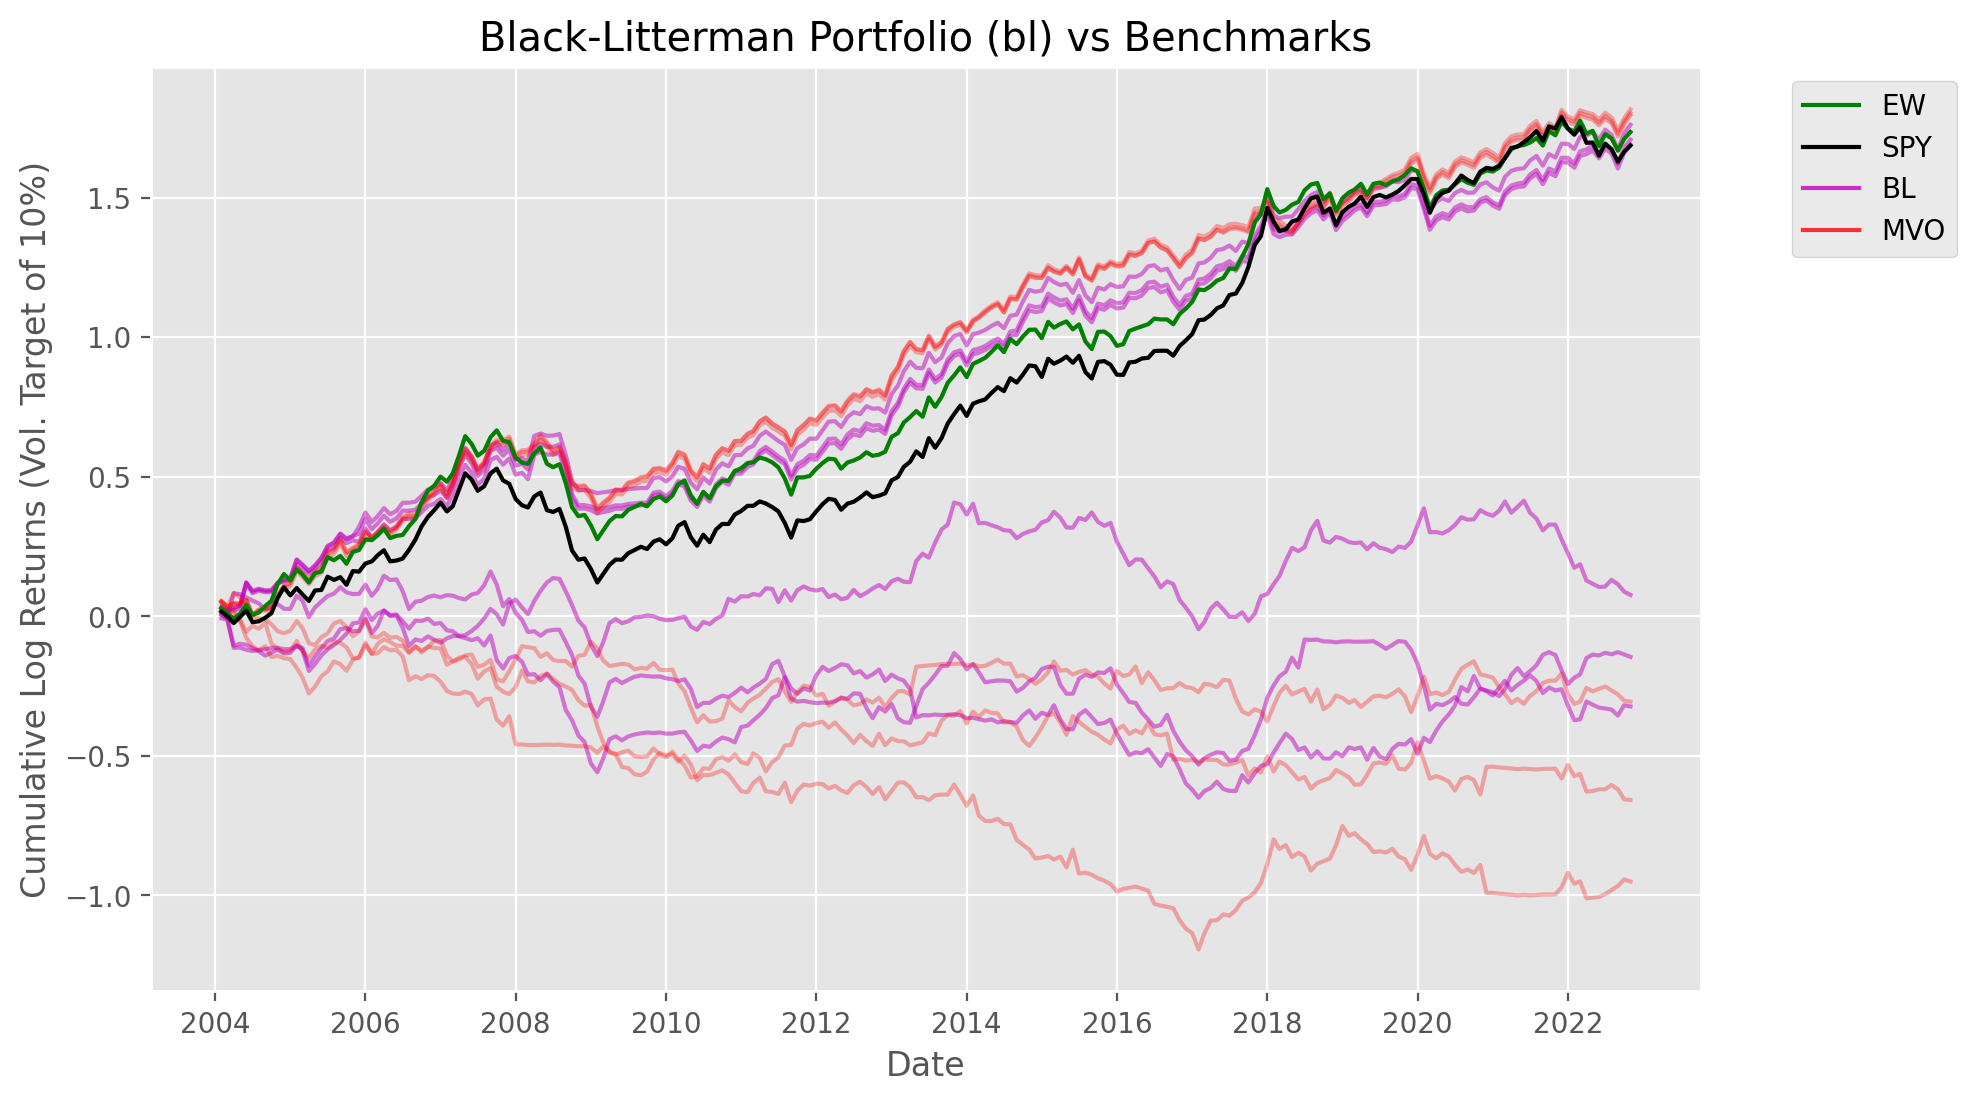

In [37]:
super_benchmarks = ['spy', 'ew']
selected_model_list = [
    'bl_lns_2',
    'bl_lo_2',
    'bl_lns_3',
    'bl_lo_3',
    'bl_lns_4',
    'bl_lo_4',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if m.startswith('bl')]
mvo_models = [m for m in selected_model_list if m.startswith('mvo')]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='m', alpha=0.5)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='m', label='BL', alpha=0.8)
plt.plot([], [], color='red', label='MVO', alpha=0.8)

plt.title(f"Black-Litterman Portfolio (bl) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [38]:
all_summary_statistics = []
for model in cum_voladj_returns.columns:
    tmp_portfolio_returns = cum_voladj_returns[[model]].diff()

    tensor_tmp_portfolio_returns = torch.tensor(tmp_portfolio_returns.dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df.round(3)

E[R]  Std(R)  Sharpe  Sortino   AvgDD   MaxDD  % Positive Ret.
bl_lns_2  -0.737  37.398  -0.068   -0.092 -21.963 -43.996            0.520
bl_lo_2    9.214  36.069   0.885    1.299  -3.694 -19.250            0.662
bl_lns_3   0.369  37.137   0.034    0.051 -11.057 -36.485            0.516
bl_lo_3    8.939  36.222   0.855    1.242  -3.989 -20.924            0.667
bl_lns_4  -1.752  36.244  -0.167   -0.243 -31.675 -55.532            0.484
bl_lo_4    8.881  35.870   0.858    1.265  -3.703 -19.778            0.653
mvo_lns_2 -3.603  35.070  -0.356   -0.537 -32.888 -48.780            0.453
mvo_lo_2   9.398  35.376   0.920    1.427  -3.108 -22.897            0.627
mvo_lns_3 -1.909  34.168  -0.194   -0.302 -25.141 -37.099            0.511
mvo_lo_3   9.284  35.366   0.909    1.414  -3.147 -23.052            0.627
mvo_lns_4 -5.306  35.900  -0.512   -0.689 -46.943 -70.375            0.444
mvo_lo_4   9.334  35.385   0.914    1.413  -3.162 -23.142            0.627
spy        8.906  37.731   0.818    1.331  -6.307 -33.492            0.662
ew         9.101  37.629   0.838    1.325  -5.891 -32.286            0.662

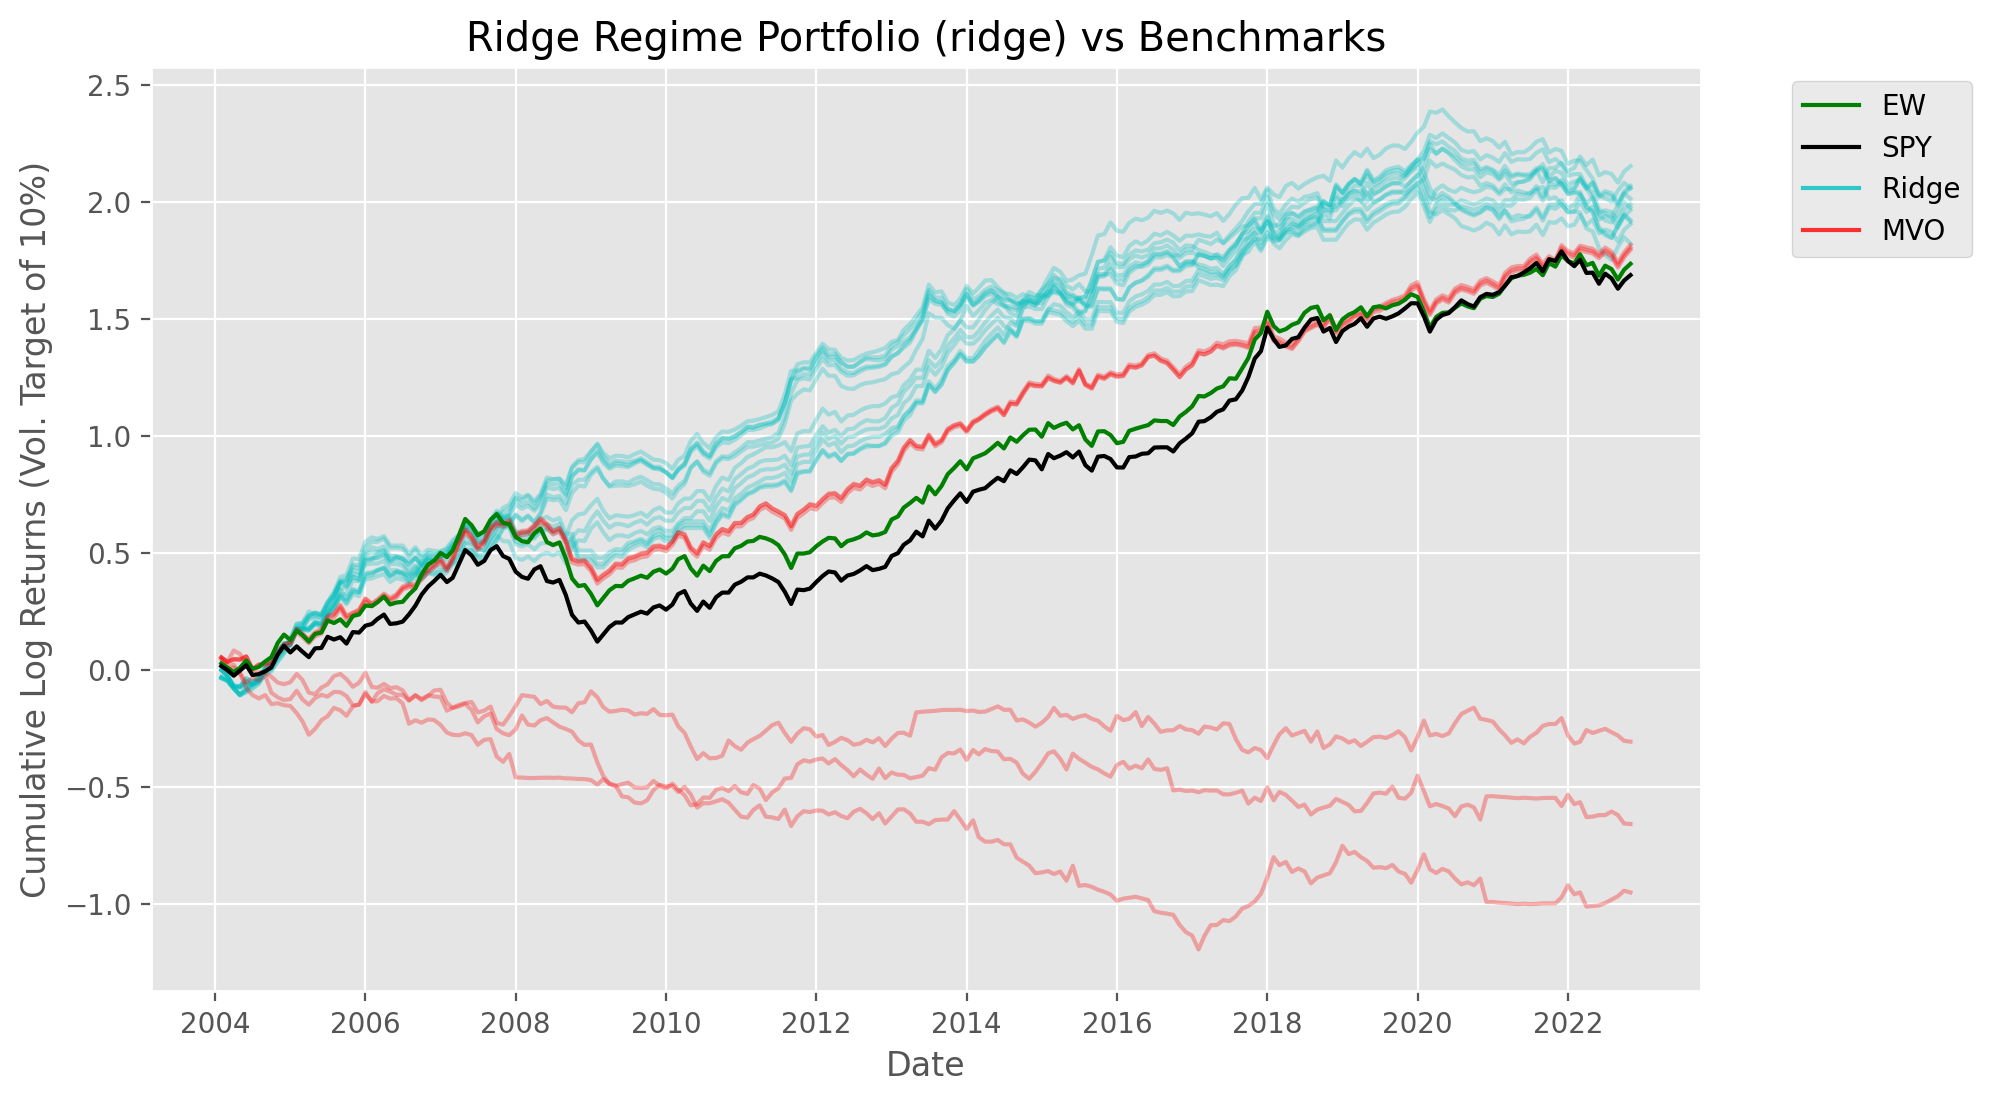

In [39]:
super_benchmarks = ['spy', 'ew']
selected_model_list = [
    'linear-ridge_lns_2',
    'linear-ridge_mx_2',
    'linear-ridge_los_2',
    'linear-ridge_lo_2',
    'linear-ridge_lns_3',
    'linear-ridge_mx_3',
    'linear-ridge_los_3',
    'linear-ridge_lo_3',
    'linear-ridge_lns_4',
    'linear-ridge_mx_4',
    'linear-ridge_los_4',
    'linear-ridge_lo_4',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if m.startswith('linear-ridge')]
mvo_models = [m for m in selected_model_list if m.startswith('mvo')]

# Define colors for each group
colors = {
   'linear-ridge': 'red',
   'mvo': 'blue', 
   'ew': 'green',
   'spy': 'black'
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='c', alpha=0.3)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='c', label='Ridge', alpha=0.8)
plt.plot([], [], color='red', label='MVO', alpha=0.8)

plt.title(f"Ridge Regime Portfolio (ridge) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [40]:
all_summary_statistics = []
for model in cum_voladj_returns.columns:
    tmp_portfolio_returns = cum_voladj_returns[[model]].diff()

    tensor_tmp_portfolio_returns = torch.tensor(tmp_portfolio_returns.dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df.round(3)

E[R]  Std(R)  Sharpe  Sortino   AvgDD   MaxDD  \
linear-ridge_lns_2  11.127  37.586   1.026    2.061  -4.121 -32.491   
linear-ridge_mx_2   10.609  36.186   1.016    1.655  -4.443 -23.082   
linear-ridge_los_2  10.684  37.454   0.988    1.987  -4.113 -28.529   
linear-ridge_lo_2   11.479  36.178   1.099    1.620  -3.041 -18.234   
linear-ridge_lns_3  10.394  37.398   0.963    1.962  -4.145 -33.798   
linear-ridge_mx_3   10.160  36.104   0.975    1.592  -4.109 -22.404   
linear-ridge_los_3  10.927  37.483   1.010    2.125  -3.839 -30.004   
linear-ridge_lo_3   10.981  36.099   1.054    1.561  -2.990 -18.525   
linear-ridge_lns_4   9.901  37.376   0.918    1.816  -4.183 -34.590   
linear-ridge_mx_4   10.474  36.049   1.007    1.621  -4.175 -22.884   
linear-ridge_los_4  10.429  37.317   0.968    1.928  -4.007 -31.716   
linear-ridge_lo_4   11.036  35.999   1.062    1.555  -3.095 -19.458   
mvo_lns_2           -3.603  35.070  -0.356   -0.537 -32.888 -48.780   
mvo_lo_2             9.398  35.376   0.920    1.427  -3.108 -22.897   
mvo_lns_3           -1.909  34.168  -0.194   -0.302 -25.141 -37.099   
mvo_lo_3             9.284  35.366   0.909    1.414  -3.147 -23.052   
mvo_lns_4           -5.306  35.900  -0.512   -0.689 -46.943 -70.375   
mvo_lo_4             9.334  35.385   0.914    1.413  -3.162 -23.142   
spy                  8.906  37.731   0.818    1.331  -6.307 -33.492   
ew                   9.101  37.629   0.838    1.325  -5.891 -32.286   

                    % Positive Ret.  
linear-ridge_lns_2            0.618  
linear-ridge_mx_2             0.609  
linear-ridge_los_2            0.618  
linear-ridge_lo_2             0.604  
linear-ridge_lns_3            0.591  
linear-ridge_mx_3             0.596  
linear-ridge_los_3            0.618  
linear-ridge_lo_3             0.591  
linear-ridge_lns_4            0.578  
linear-ridge_mx_4             0.587  
linear-ridge_los_4            0.596  
linear-ridge_lo_4             0.591  
mvo_lns_2                     0.453  
mvo_lo_2                      0.627  
mvo_lns_3                     0.511  
mvo_lo_3                      0.627  
mvo_lns_4                     0.444  
mvo_lo_4                      0.627  
spy                           0.662  
ew                            0.662

In [ ]:
# ew_vol_scale = 10 / (equal_weight_cumm_returns.rolling(window=3).std() * 12 * 100)
# tensor_scaled_equal_weight_cumm_returns = torch.tensor((equal_weight_cumm_returns * ew_vol_scale).dropna().values)
ew_summary_statistics = compute_summary_statistics(torch.tensor(equal_weight_cumm_returns.values))
ew_summary_statistics = pd.DataFrame([ew_summary_statistics], index=["EW"])

all_summary_statistics = []
for model in model_list:
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

In [114]:
all_summary_statistics_df.head(20)

E[R]     Std(R)    Sharpe   Sortino      AvgDD  \
naive_lns_2       4.838992  25.736531  0.651322  1.983899  -4.162020   
naive_mx_2        3.952692  17.710388  0.773135  1.771322  -3.524086   
naive_los_2       3.979019  17.315257  0.796045  1.742465  -3.900600   
naive_lo_2        4.673959  16.500923  0.981222  2.532410  -1.544985   
naive_lns_3       8.884642  76.646072  0.401551  3.532935  -3.545313   
naive_mx_3        4.293688  20.105569  0.739784  1.948415  -3.134988   
naive_los_3       5.273663  32.156573  0.568111  2.356949  -3.214385   
naive_lo_3        5.008405  19.300558  0.898918  2.630146  -1.403630   
naive_mx_4        3.677039  17.067149  0.746325  1.485978  -3.897023   
naive_lns_4       3.430283  16.189683  0.733977  1.206821  -4.232176   
naive_los_4       4.032058  17.718271  0.788308  1.618071  -3.438880   
naive_lo_4        4.830363  15.714140  1.064829  2.540543  -1.481599   
naive_lns_2_rand  5.535561  23.221949  0.825760  2.205453  -1.556644   
naive_mx_2_rand   0.715070  13.122578  0.188764  0.316086  -3.903064   
naive_los_2_rand -1.334429  18.680331 -0.247458 -0.236979 -22.307176   
naive_lo_2_rand   1.680977  12.005731  0.485025  0.762849  -2.105750   
naive_lns_3_rand  1.592222  13.585089  0.406005  0.782389  -2.434845   
naive_mx_3_rand   2.037679  19.595937  0.360214  0.371808 -10.276713   
naive_los_3_rand  0.723384  13.127992  0.190880  0.338502  -4.297351   
naive_lo_3_rand   3.903896  19.316262  0.700109  0.796519  -3.634985   

                      MaxDD  % Positive Ret.  
naive_lns_2      -14.941776         0.580357  
naive_mx_2       -14.642661         0.584821  
naive_los_2      -14.595108         0.580357  
naive_lo_2        -6.162702         0.540179  
naive_lns_3      -16.148244         0.558036  
naive_mx_3       -14.680858         0.575893  
naive_los_3      -14.772553         0.558036  
naive_lo_3        -5.858757         0.536364  
naive_mx_4       -17.807080         0.589286  
naive_lns_4      -17.699095         0.580357  
naive_los_4      -17.064206         0.580357  
naive_lo_4        -6.719434         0.549107  
naive_lns_2_rand -11.965943         0.589286  
naive_mx_2_rand  -14.952657         0.526786  
naive_los_2_rand -35.723582         0.482143  
naive_lo_2_rand   -9.030330         0.486607  
naive_lns_3_rand  -7.444444         0.540179  
naive_mx_3_rand  -23.039622         0.558036  
naive_los_3_rand -11.956307         0.513393  
naive_lo_3_rand  -20.372310         0.517857

## Nemenyi Test

In [115]:
def nemenyi_test(metric_values, control, treatment, alpha=0.05):
   # Prepare data matrix where rows are samples and columns are methods
   data = np.array([metric_values[control], metric_values[treatment]]).T
   
   # Calculate ranks for each row
   ranks = np.array([stats.rankdata(row) for row in data])
   mean_ranks = np.mean(ranks, axis=0)
   
   # Calculate critical distance
   k = 2  # number of methods being compared
   n = len(control)  # number of samples
   q = stats.studentized_range.ppf(1 - alpha, k, np.inf) / np.sqrt(2)
   cd = q * np.sqrt((k * (k + 1)) / (6 * n))
   
   return mean_ranks, cd

In [118]:
returns = pd.concat(concat_list, axis=1).copy()
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()

metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["naive_lns_2_rand", "naive_lo_2_rand", "naive_lns_3_rand", "naive_lo_3_rand", "naive_lns_4_rand", "naive_lo_4_rand"]
treatment = ["naive_lns_2", "naive_lo_2", "naive_lns_3", "naive_lo_3", "naive_lns_4", "naive_lo_4"]

results = []
for metric_name in metric_names:
   metric_values = voladj_returns.apply(lambda x: compute_summary_statistics(torch.tensor(x.values))[metric_name], axis=0)
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.167           1.833    0.016
1          Sortino         1.000           2.000    0.021
2            MaxDD         1.500           1.500    0.661
3  % Positive Ret.         1.250           1.750    0.075


In [41]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["mvo_lns_2", "mvo_lo_2", "mvo_lns_3", "mvo_lo_3", "mvo_lns_4", "mvo_lo_4"]
treatment = ["bl_lns_2", "bl_lo_2", "bl_lns_3", "bl_lo_3", "bl_lns_4", "bl_lo_4"]

results = []
for metric_name in metric_names:
   metric_values = voladj_returns.apply(lambda x: compute_summary_statistics(torch.tensor(x.values))[metric_name], axis=0)
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.500           1.500    0.109
1          Sortino         1.500           1.500    0.215
2            MaxDD         1.000           2.000    0.034
3  % Positive Ret.         1.000           2.000    0.003


In [119]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["linear-ridge_lns_2_rand", "linear-ridge_lo_2_rand", "linear-ridge_lns_3_rand", "linear-ridge_lo_3_rand", "linear-ridge_lns_4_rand", "linear-ridge_lo_4_rand"]
treatment = ["linear-ridge_lns_2", "linear-ridge_lo_2", "linear-ridge_lns_3", "linear-ridge_lo_3", "linear-ridge_lns_4", "linear-ridge_lo_4"]

results = []
for metric_name in metric_names:
   metric_values = voladj_returns.apply(lambda x: compute_summary_statistics(torch.tensor(x.values))[metric_name], axis=0)
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         2.000           1.000    0.994
1          Sortino         2.000           1.000    0.999
2            MaxDD         2.000           1.000    1.000
3  % Positive Ret.         1.750           1.250    0.964


## T-test for Two Related Samples ($H_0: \mu_c > \mu_t$)

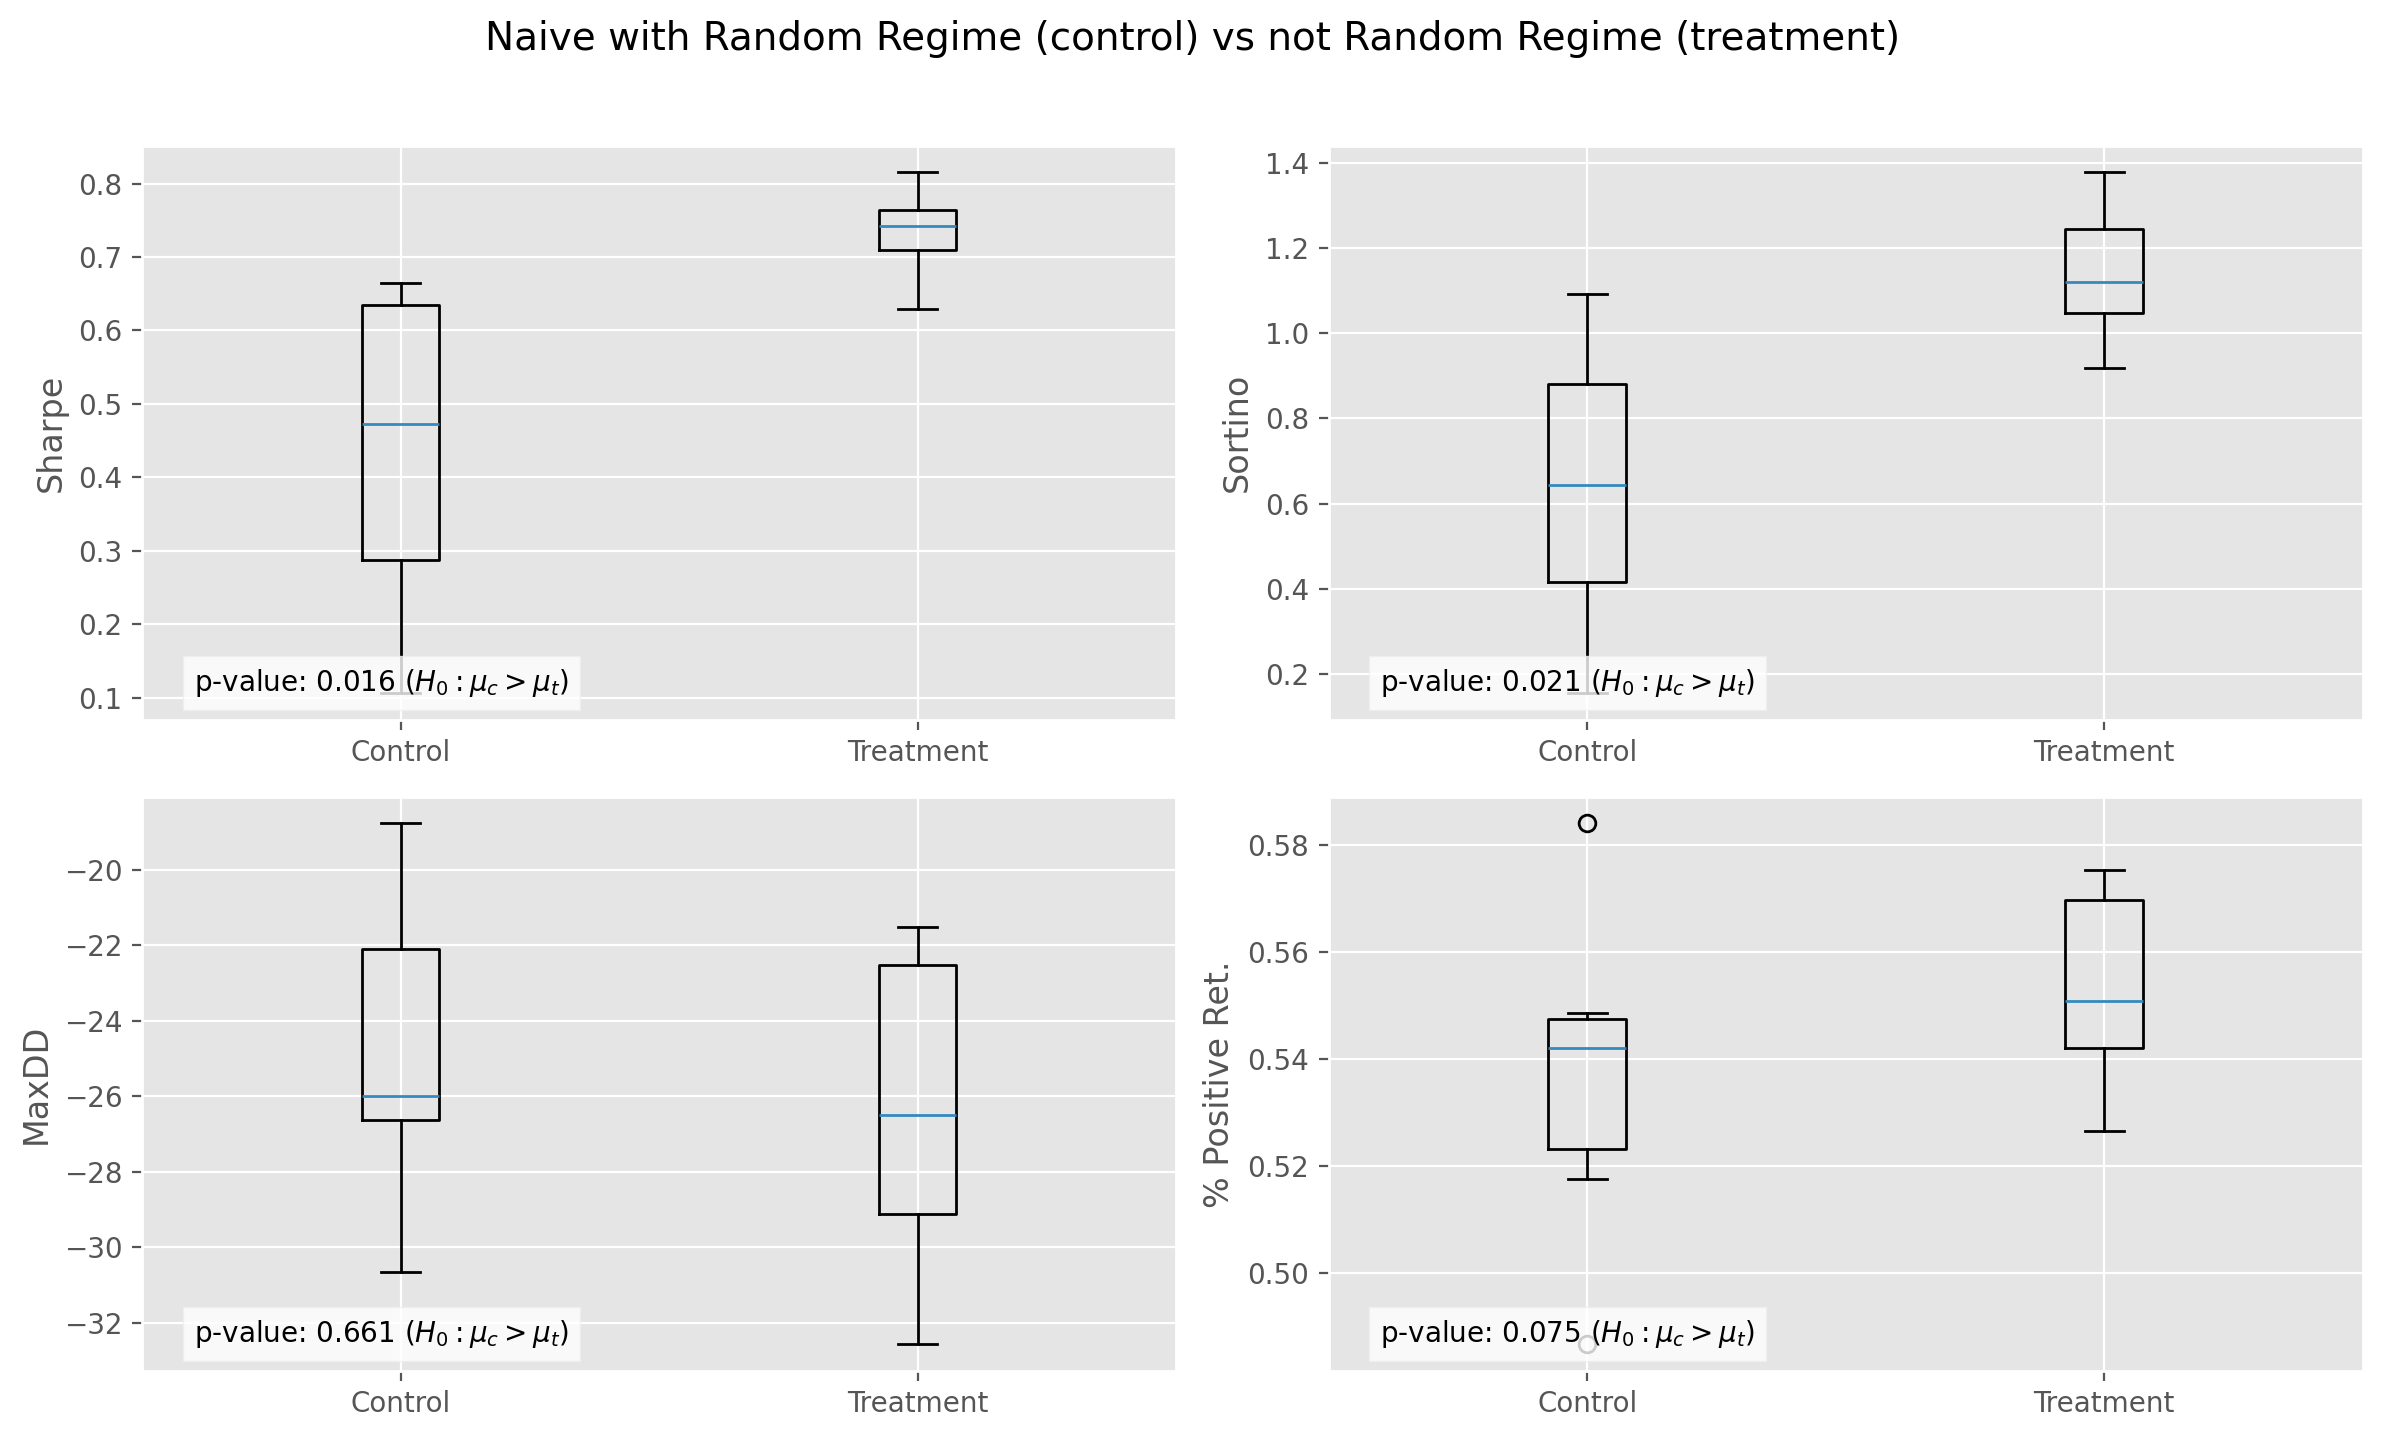

In [120]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["naive_lns_2_rand", "naive_lo_2_rand", "naive_lns_3_rand", "naive_lo_3_rand", "naive_lns_4_rand", "naive_lo_4_rand"]
treatment = ["naive_lns_2", "naive_lo_2", "naive_lns_3", "naive_lo_3", "naive_lns_4", "naive_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('Naive with Random Regime (control) vs not Random Regime (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = voladj_returns.apply(lambda x: compute_summary_statistics(torch.tensor(x.values))[metric_name], axis=0)
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, tick_labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

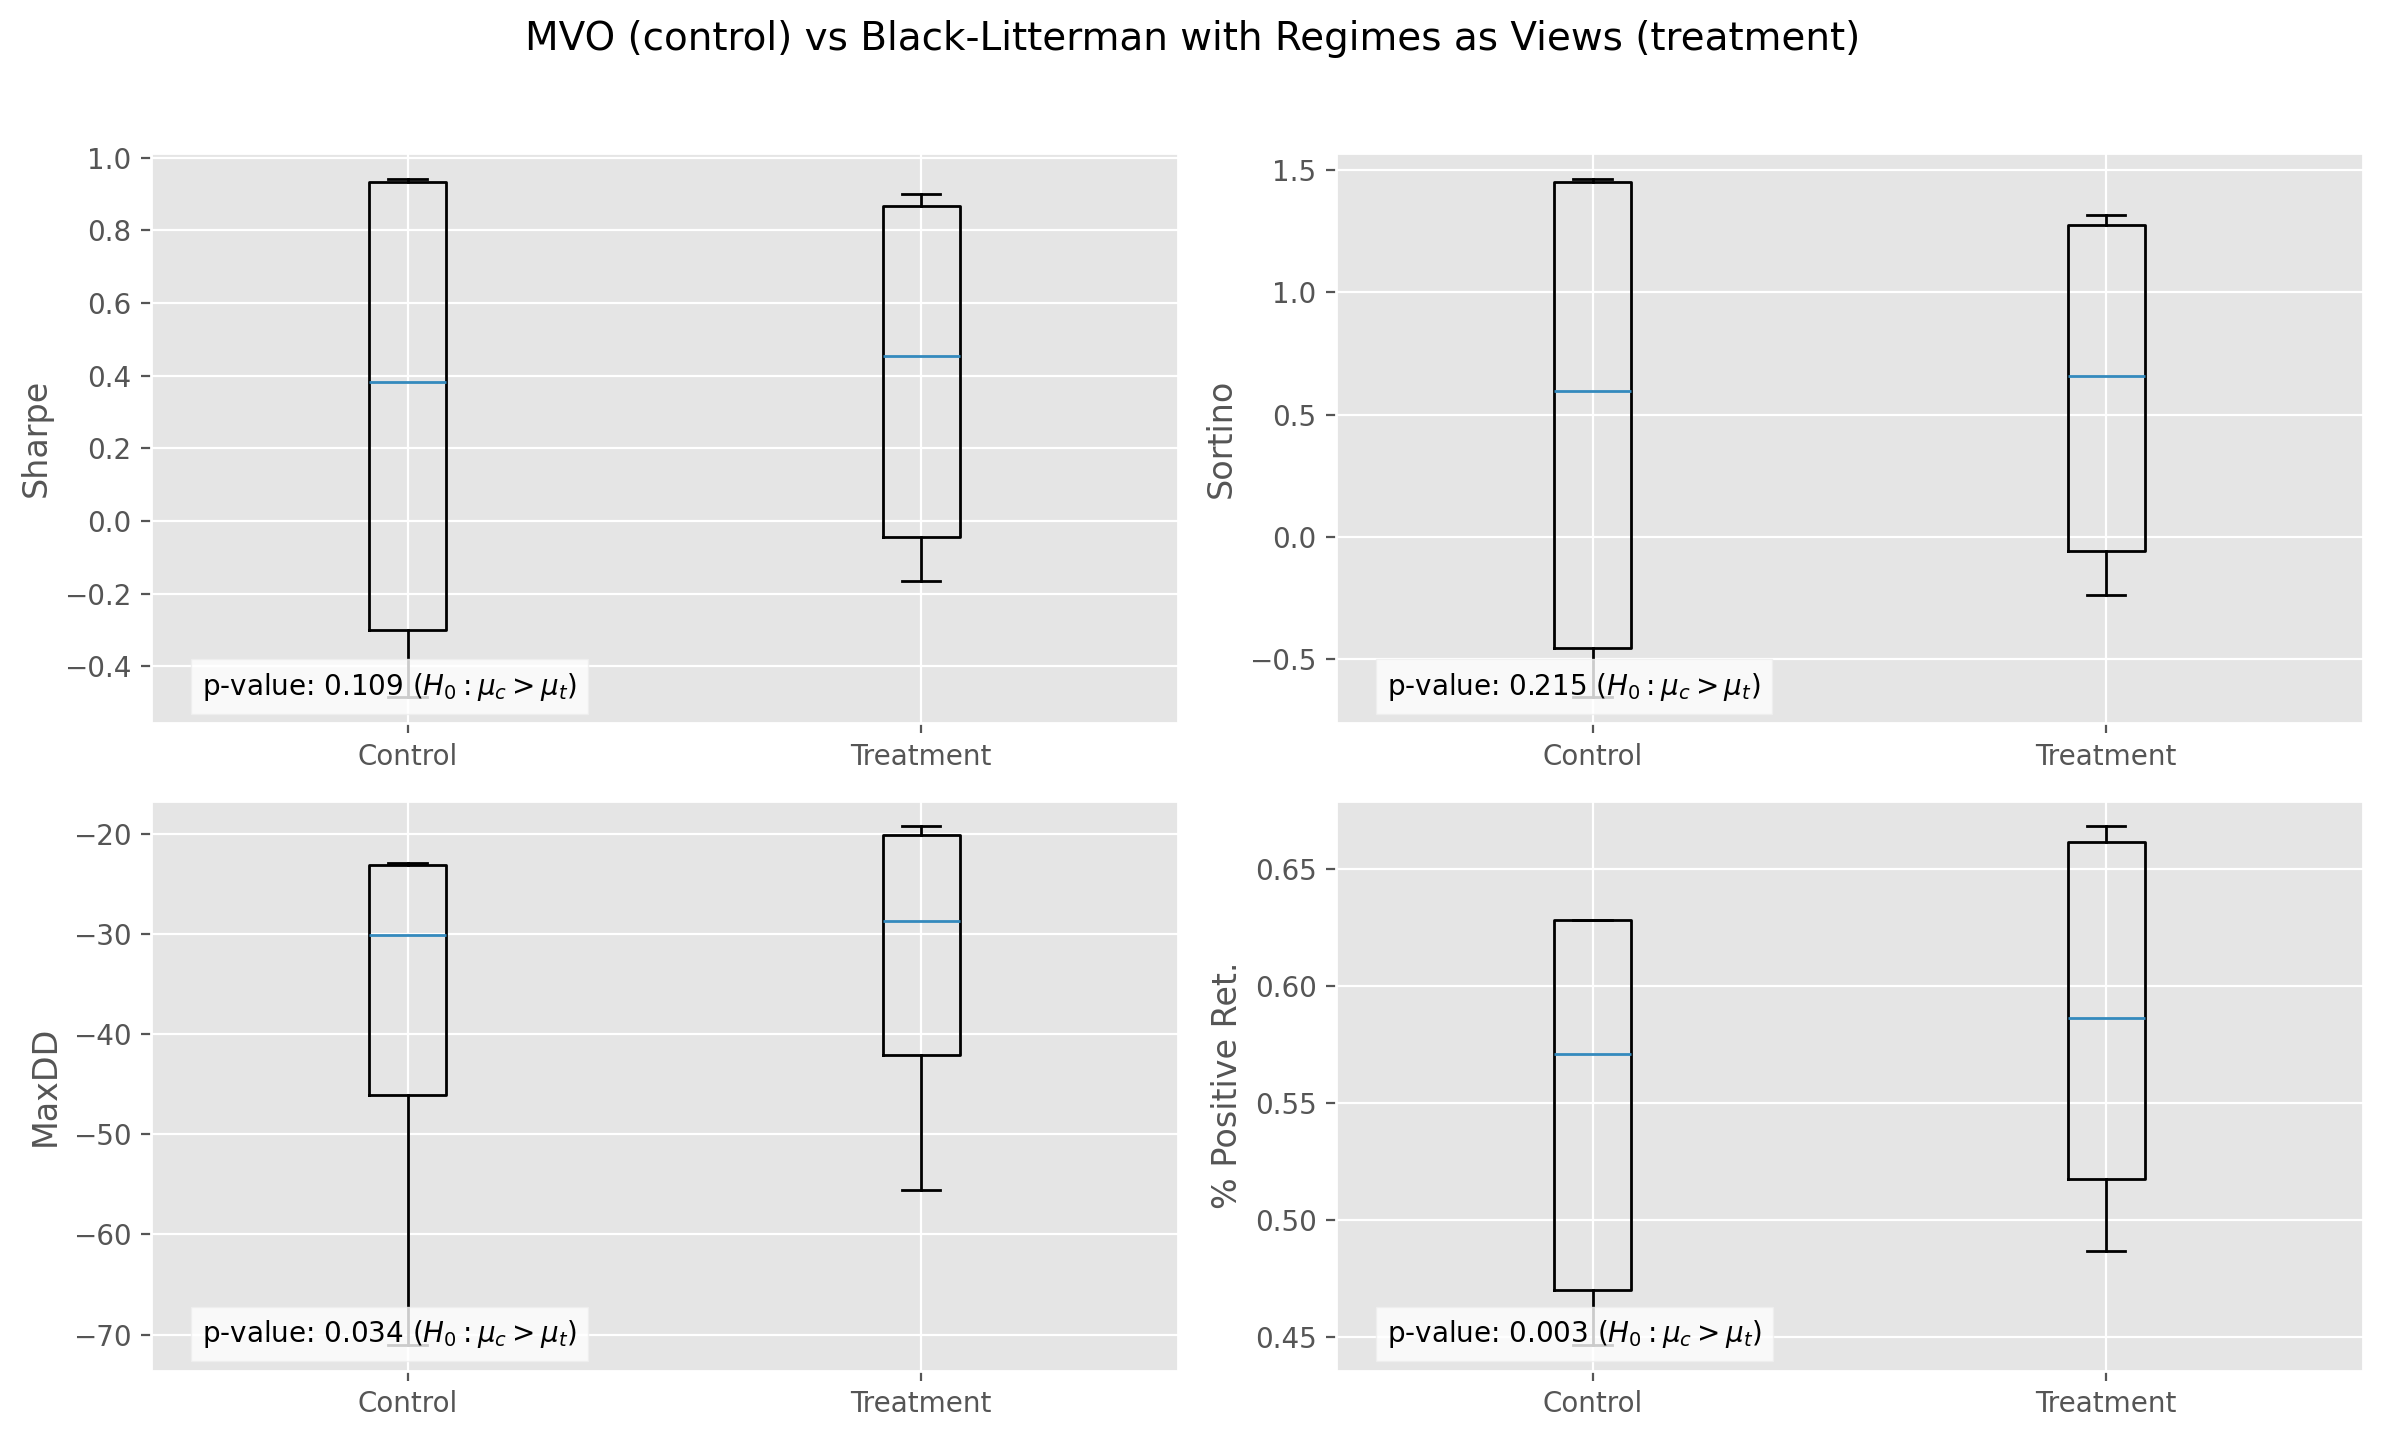

In [122]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["mvo_lns_2", "mvo_lo_2", "mvo_lns_3", "mvo_lo_3", "mvo_lns_4", "mvo_lo_4"]
treatment = ["bl_lns_2", "bl_lo_2", "bl_lns_3", "bl_lo_3", "bl_lns_4", "bl_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('MVO (control) vs Black-Litterman with Regimes as Views (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = voladj_returns.apply(lambda x: compute_summary_statistics(torch.tensor(x.values))[metric_name], axis=0)
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, tick_labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

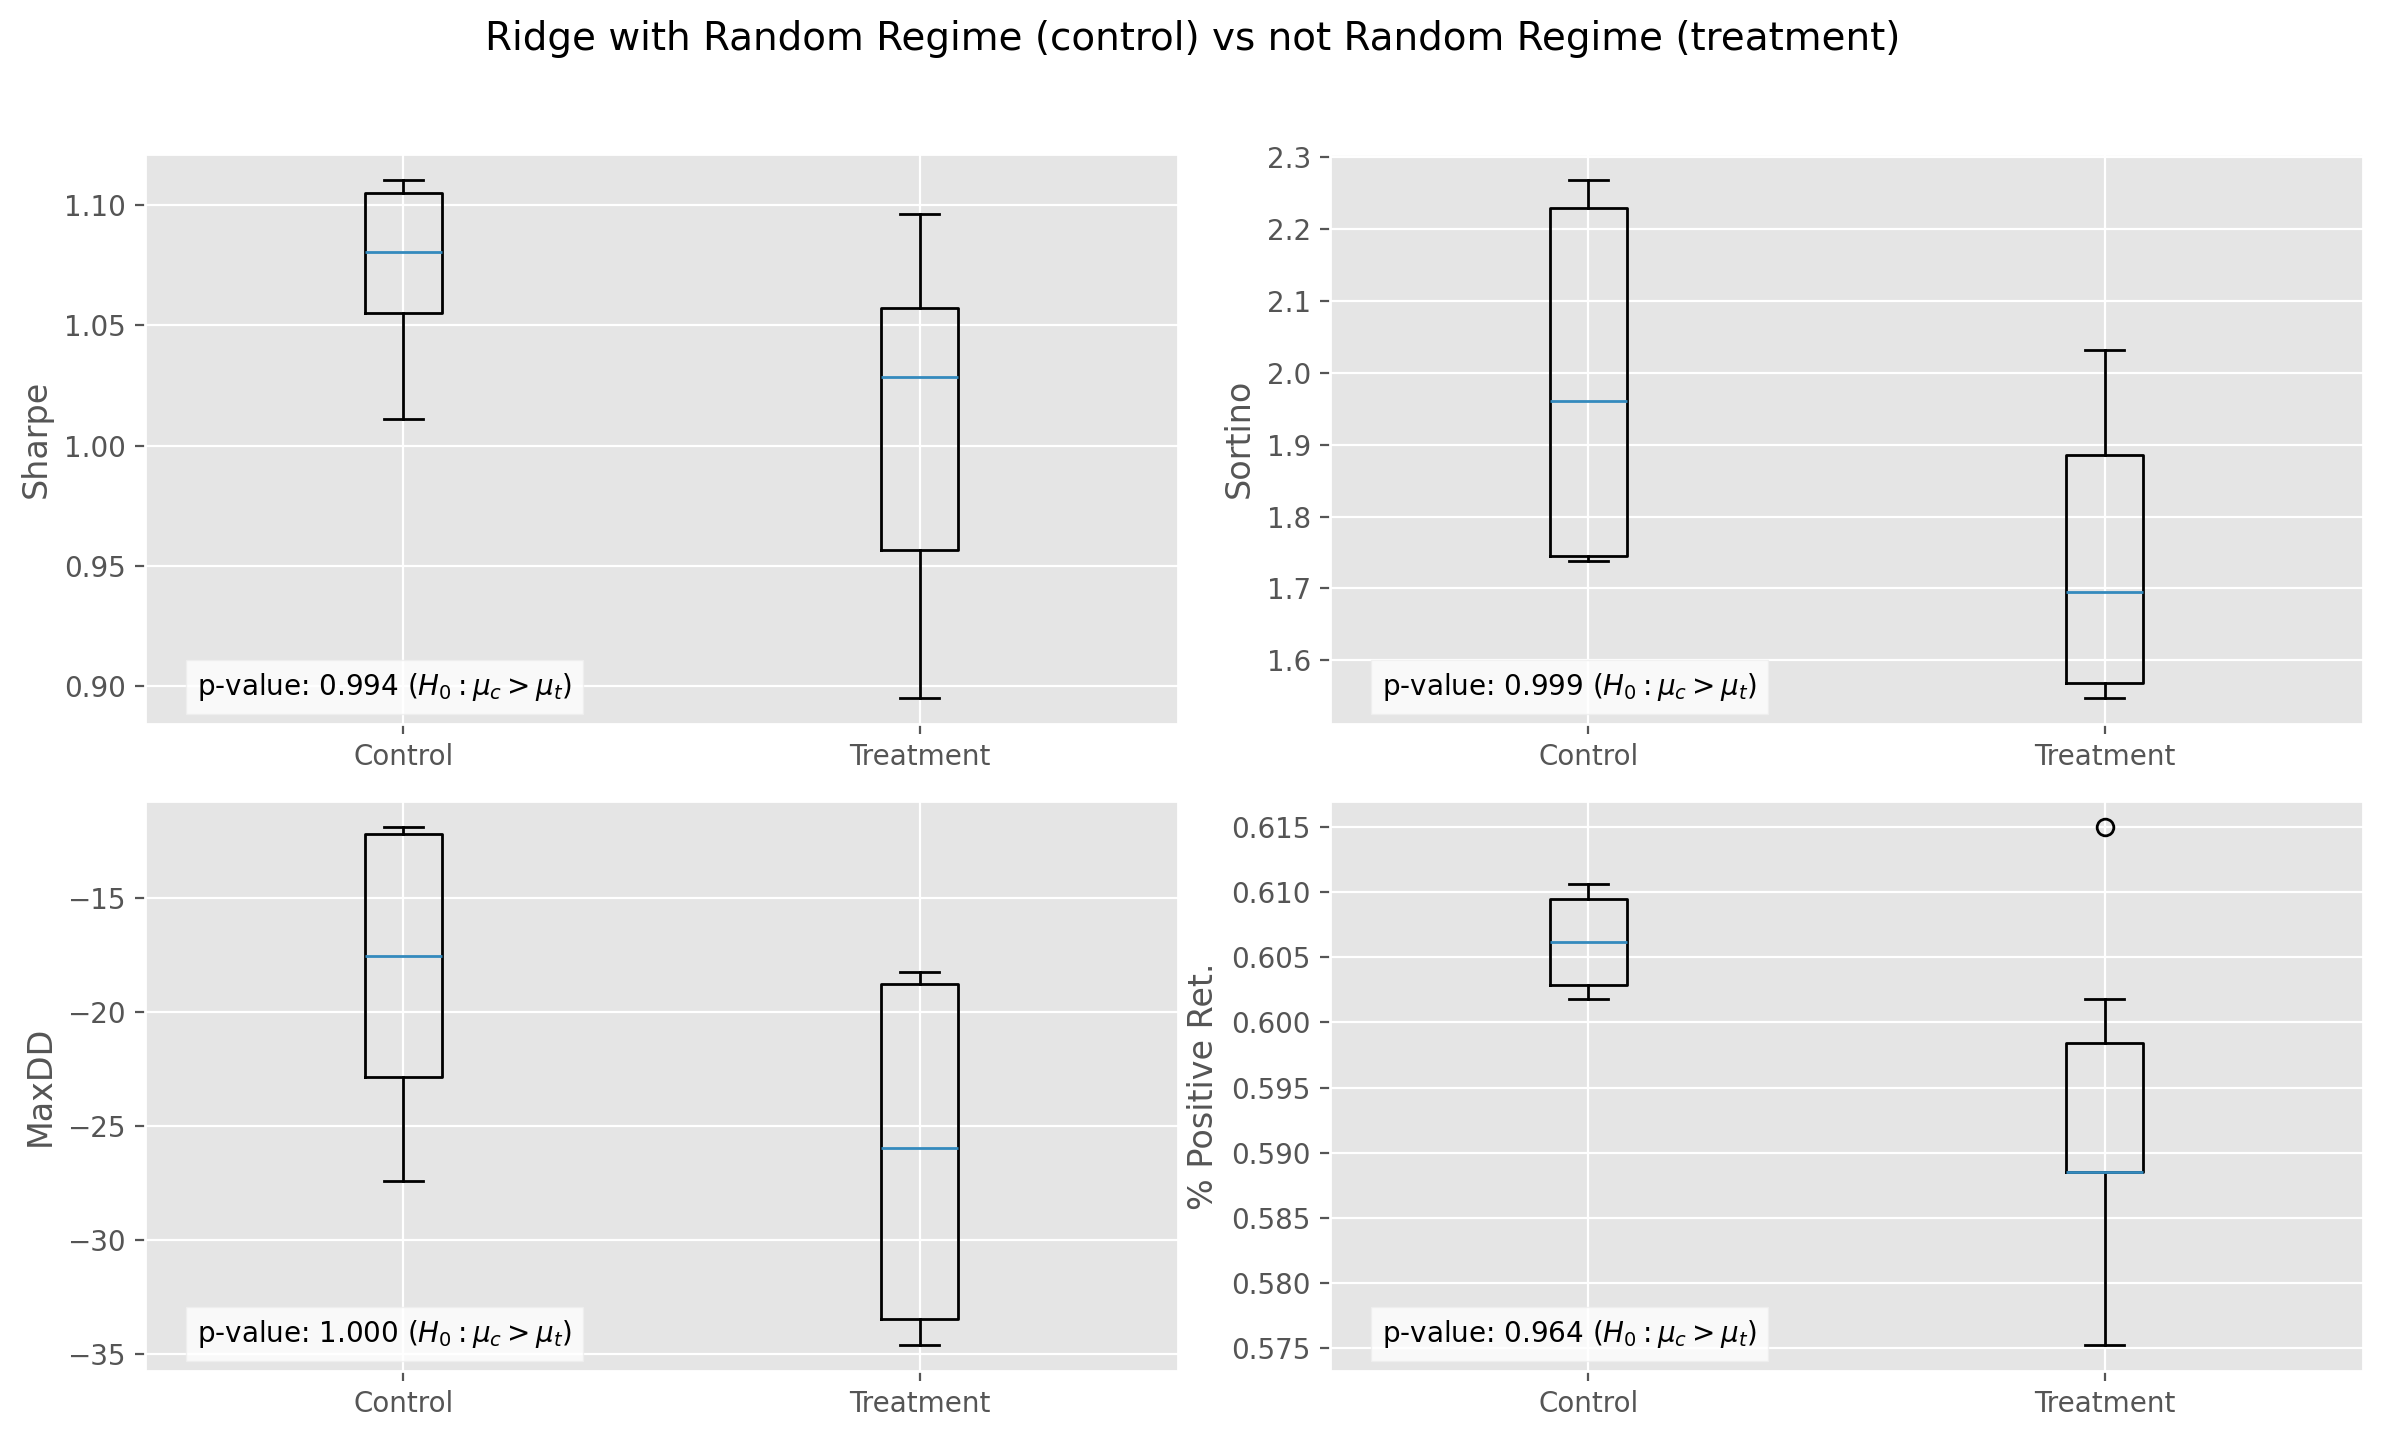

In [123]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["linear-ridge_lns_2_rand", "linear-ridge_lo_2_rand", "linear-ridge_lns_3_rand", "linear-ridge_lo_3_rand", "linear-ridge_lns_4_rand", "linear-ridge_lo_4_rand"]
treatment = ["linear-ridge_lns_2", "linear-ridge_lo_2", "linear-ridge_lns_3", "linear-ridge_lo_3", "linear-ridge_lns_4", "linear-ridge_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()
fig.suptitle('Ridge with Random Regime (control) vs not Random Regime (treatment)', fontsize=14, y=1.02)

for i, metric_name in enumerate(metric_names):
   metric_values = voladj_returns.apply(lambda x: compute_summary_statistics(torch.tensor(x.values))[metric_name], axis=0)
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, tick_labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()